<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/ml-mipt_advanced/VAE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook is inspired by and based on [this demonstration of VAE in keras](https://github.com/msurtsukov/ae_vae_gan)

In [ ]:
%matplotlib inline

In [ ]:
from torchsummary import summary
import seaborn as sns
sns.set()

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
print(device)

cuda:0


In [ ]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))


class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

In [ ]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
#     transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [ ]:
data_root = '.'

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )
        input_dim = np.prod(input_shape)
        self.encoder = nn.Sequential(*[
            Flatten(),
            nn.Linear(input_dim, intermediate_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], intermediate_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3)
        ])
        
        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim) # <YOUR CODE HERE>
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)# <YOUR CODE HERE> 
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim, intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[1], intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], input_dim),
            nn.Sigmoid(),
            RestoreShape(input_shape)
        ])
    
    def _encode(self, x):
        latent_repr = self.encoder(x)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = sample * torch.exp(log_sigma_values) + mu_values# <YOUR CODE HERE>
        return latent_sample

    def forward(self, x, raw_sample=None):
        mu_values, log_sigma_values, latent_repr = self._encode(x)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        
        reconstructed_repr = self.decoder(latent_sample)
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values



class ConvolutionalCVAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, label_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc = self._initial_mu,
            scale = self._initial_sigma)
        
        input_dim = np.prod(input_shape)

        self.encoder_conv = torch.nn.Sequential(*[torch.nn.Conv2d(1, 8, kernel_size = 3),
                                            torch.nn.Dropout(.3),
                                            torch.nn.BatchNorm2d(8),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size = 2),

                                            torch.nn.Conv2d(8, 16, kernel_size = 5),
                                            torch.nn.Dropout(.3),
                                            torch.nn.BatchNorm2d(16),
                                            torch.nn.MaxPool2d(kernel_size = 3),

                                            torch.nn.Conv2d(16, latent_dim, kernel_size = 2),
                                            torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(kernel_size = 2),
                                            torch.nn.Flatten(),
                                            ])
        
        self.encoder_fc = torch.nn.Sequential(*[
            nn.Linear(latent_dim + label_dim, intermediate_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.25),
            ])
       
        self.mu_repr = nn.Linear(intermediate_dims[0], latent_dim) # <YOUR CODE HERE>
        self.log_sigma_repr = nn.Linear(intermediate_dims[0], latent_dim)# <YOUR CODE HERE> 
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim + label_dim, intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Linear(intermediate_dims[0], latent_dim),

            Reshape(latent_dim, 1, 1),
            torch.nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, 0, bias = False),
            nn.Dropout(0.2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(),
        
            torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(),
        
            torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias = False),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),

            torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias = False),
            torch.nn.LeakyReLU(),

            nn.Sigmoid(),
            RestoreShape(input_shape)])
    
    def _encode(self, x, c):
        latent_repr_conv = self.encoder_conv(x)
        # print(latent_repr_conv.shape)
        latent_repr = self.encoder_fc(torch.cat([latent_repr_conv, c], 1))
      
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = sample * torch.exp(log_sigma_values) + mu_values# <YOUR CODE HERE>
        return latent_sample

    def forward(self, x, c, raw_sample = None):
        mu_values, log_sigma_values, latent_repr = self._encode(x, c)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        latent_sample = torch.cat([latent_sample, c], 1)
        # print(latent_sample.shape)
        reconstructed_repr = self.decoder(latent_sample)
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [ ]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # plt.show()
    return fig


In [ ]:
label_dim = train_loader.dataset.train_labels.unique().size(0)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
def loss_function(recon_x, x, mu_values, log_sigma_values):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction = 'sum')
    KLD = -0.5 * torch.mean(1 + log_sigma_values - mu_values.pow(2) - log_sigma_values.exp())
    return (BCE + KLD) 

In [ ]:
example_batch_x, example_batch_y = next(iter(train_loader))
example_batch_x = example_batch_x.to(device)
example_batch_y = F.one_hot(example_batch_y, num_classes = label_dim).to(device).to(device) 

model = ConvolutionalCVAE([256], 2, label_dim, example_batch_x[0].shape).to(device)
opt = torch.optim.Adam(model.parameters(), lr = 3 * 1e-4)

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch_x,
                                                                       example_batch_y)


In [ ]:
summary(model, [1, 28, 28, 10])


In [ ]:
test_batch = next(iter(test_loader))

In [ ]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        out = model(test_batch[0].to(device), F.one_hot(test_batch[1], num_classes = label_dim).to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [ ]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            c_sample = np.zeros((1, label_dim))

            z_sample[:, :2] = np.array([[xi, yi]])
            
            z_torch = torch.from_numpy(np.concatenate([z_sample, c_sample], axis = 1)).type(torch.FloatTensor).to(device)
            
            x_decoded = model.decoder(z_torch).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
#         plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

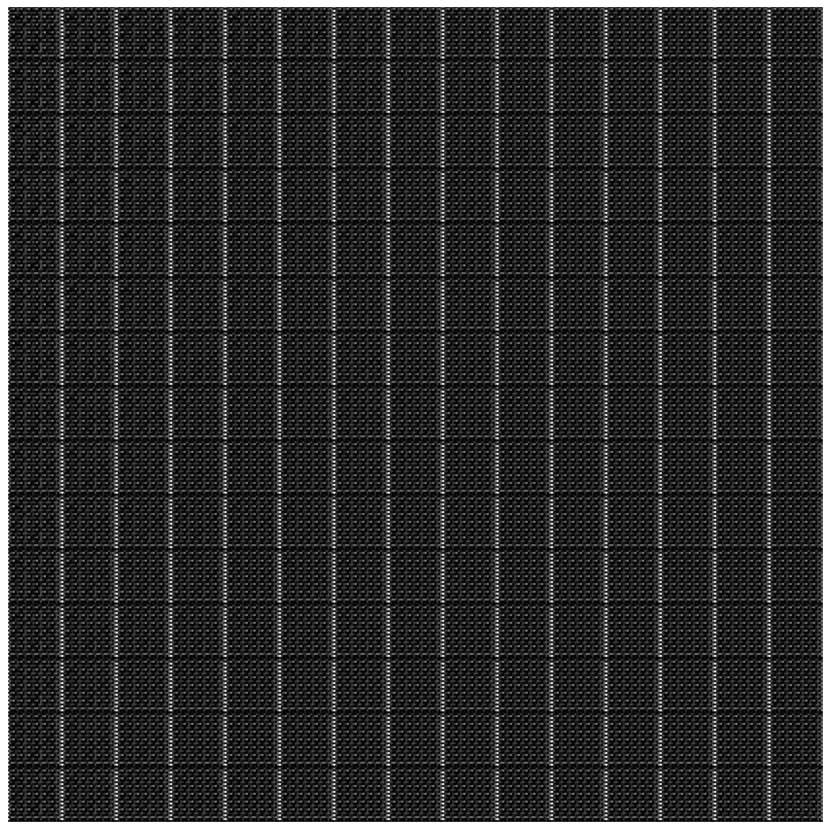

In [ ]:
model.eval()
_img = draw_manifold(model, True)

In [ ]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [ ]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = F.one_hot(batch_label,  num_classes = label_dim).to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x, batch_label)
            # print(predictions.shape, batch_x.shape)

            kl_loss = 0.5 * torch.mean(torch.sum(mu_values.pow(2) + torch.exp(log_sigma_values) - log_sigma_values - 1, dim = -1)) # <YOUR CODE HERE>
            bce_loss = 0.5 * 28 * 28 * torch.nn.BCELoss()(predictions, batch_x)
            loss = (bce_loss + kl_loss) /(2. * 28. * 28.)
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss/(len(train_loader.dataset))
            bce_acc += bce_loss/(len(train_loader.dataset))
            kl_acc += kl_loss/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.6f}, KL divergence={:.6f}, BCE Loss={:.6f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [ ]:
epochs, figs, latent_distrs = train(num_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch num: 0
Training loss=0.000684, KL divergence=0.001275, BCE Loss=1.071843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch num: 5
Training loss=0.000636, KL divergence=0.000160, BCE Loss=0.996958


Epoch num: 10
Training loss=0.000506, KL divergence=0.000049, BCE Loss=0.793897


Epoch num: 15
Training loss=0.000366, KL divergence=0.000020, BCE Loss=0.573476


Epoch num: 20
Training loss=0.000284, KL divergence=0.000015, BCE Loss=0.445371


Epoch num: 25
Training loss=0.000245, KL divergence=0.000873, BCE Loss=0.382642


Epoch num: 30
Training loss=0.000225, KL divergence=0.001962, BCE Loss=0.350246


Epoch num: 35
Training loss=0.000215, KL divergence=0.002338, BCE Loss=0.335274


Epoch num: 40
Training loss=0.000210, KL divergence=0.002549, BCE Loss=0.327351


Epoch num: 45
Training loss=0.000207, KL divergence=0.002839, BCE Loss=0.321700


Epoch num: 50
Training loss=0.000204, KL divergence=0.003194, BCE Loss=0.316907


Epoch num: 55
Training loss=0.000203, KL divergence=0.003326, BCE Loss=0.314527


Epoch num: 60
Training loss=0.000202, KL divergence=0.003383, BCE Loss=0.312691


Epoch num: 65
Training loss=0.000201, KL divergence=0.003461, BCE Loss=0.311685


Epoch num: 70
Training loss=0.000201, KL divergence=0.003513, BCE Loss=0.311088


Epoch num: 75
Training loss=0.000200, KL divergence=0.003564, BCE Loss=0.310586


Epoch num: 80
Training loss=0.000200, KL divergence=0.003635, BCE Loss=0.309873


Epoch num: 85
Training loss=0.000199, KL divergence=0.003802, BCE Loss=0.308950


Epoch num: 90
Training loss=0.000199, KL divergence=0.003875, BCE Loss=0.308740


Epoch num: 95
Training loss=0.000199, KL divergence=0.003918, BCE Loss=0.308045


In [ ]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

<Figure size 720x720 with 0 Axes>

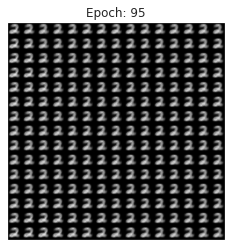

<Figure size 720x720 with 0 Axes>

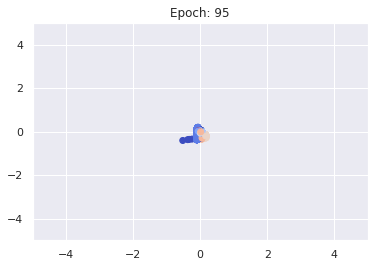

In [ ]:
import os
os.makedirs('my_figs', exist_ok=True)

from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    fig = plt.figure()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, writer='ffmpeg', fps=5)

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    fig = plt.figure()
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='ffmpeg', fps=5)
    
make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.mp4", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.mp4", plt.figure(figsize=(10,10)))

You can find your brand animations in `./my_figs/` directory ;)

Your home assignment will be to implement conditional VAE (and make in convolutional) and optionally implement GAN. 